# Time Series Forecasting of Seasonal Data using Python StatsForecast Model

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#### Get sample data: airline passenger flight data

In [2]:
df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/air-passengers.csv')
df.head()

,unique_id,ds,y
0,AirPassengers,1949-01-01,112
1,AirPassengers,1949-02-01,118
2,AirPassengers,1949-03-01,132
3,AirPassengers,1949-04-01,129
4,AirPassengers,1949-05-01,121


To use `StatsForecast` library, you data set MUST have these 3 columns present and spelled exactly as follows:
- unique_id
- ds
- y

See their [documentation](https://nixtla.github.io/statsforecast/docs/getting-started/getting_started_short.html) for more information.

It is recommended that you convert your date values in the `ds` column as actual Python date values.  If they are string values, convert them using pandas to_datetime() function.

In [3]:
df.dtypes

unique_id    object
ds           object
y             int64
dtype: object

Column `ds` is of type object/string.  So we need to convert it to an actual Python datetime object.

In [4]:
df["ds"]=pd.to_datetime(df["ds"])

In [5]:
df.dtypes

unique_id            object
ds           datetime64[ns]
y                     int64
dtype: object

## Let's split our original data into training data (70%) and test data (30%)

A common mistake that people make is fit the model on the entire data set and then compare the model results with the test data set.  Well, if you do this, of course the model fit will be very good or perfectly matched against test data set since the data the model was trained with, includes the test data.  Therefore, we must ensure that we train the model with just the training data set.  Once we are happy with our model that we trained with our training data set and our next step is to predict the future, we can then re-train our model with the entire data set.

Let's see how many data points or rows of data we have in our original data set

In [6]:
len(df)

144

Let's see what is 70% of this data set

In [7]:
len(df)*0.7

100.8

Let's round up to a whole integer

In [8]:
round(len(df)*0.7)

101

Using pandas dataframe index slicing syntax, we can create our training data set consisting of 70% of the original data

In [9]:
training_df = df[:round(len(df)*0.7)]

Let's see the last 5 rows of our training data so that we have an idea of what our test data that we are going to create next should start of with.

In [10]:
training_df.tail()

,unique_id,ds,y
96,AirPassengers,1957-01-01,315
97,AirPassengers,1957-02-01,301
98,AirPassengers,1957-03-01,356
99,AirPassengers,1957-04-01,348
100,AirPassengers,1957-05-01,355


Make note that our training data set ends with May 1957 data.  This means, we need to make sure our test data set starts with June 1957.

Now let's make our test data set of the last remaining 30% of our original data set, again using pandas dataframe slicing syntax.

In [11]:
test_df = df[round(len(df)*0.7):]

In [12]:
test_df.head()

,unique_id,ds,y
101,AirPassengers,1957-06-01,422
102,AirPassengers,1957-07-01,465
103,AirPassengers,1957-08-01,467
104,AirPassengers,1957-09-01,404
105,AirPassengers,1957-10-01,347


Our test data set starts with June 1957, which is what we want it to be.

In [13]:
len(test_df)

43

Let's confirm that the # of rows in the training data set plus the # of rows of the test data set equals 144

In [14]:
assert len(training_df) + len(test_df) == 144

## Train model with training data

In [15]:
sf = StatsForecast(
    models = [AutoARIMA(season_length = 12)],
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
    freq = 'MS'
)

sf.fit(training_df)   # Train/fit with training data, not all of the original data!

StatsForecast(models=[AutoARIMA])

#### Let's make prediction for the next 36 months and provide 90th-percentile confidence band

In [16]:
forecast_df = sf.predict(h=36, level=[90]) 

In [17]:
len(forecast_df)

36

Let's take a look at first 5 rows of our prediction or forecast data

In [18]:
forecast_df.head()

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
AirPassengers,1957-06-01,407.853333,392.134094,423.572571
AirPassengers,1957-07-01,449.223328,429.726166,468.720490
AirPassengers,1957-08-01,439.219086,415.978485,462.459686
AirPassengers,1957-09-01,392.483734,366.164581,418.802856
AirPassengers,1957-10-01,345.863403,316.756256,374.970520


In [19]:
forecast_df.tail()

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
AirPassengers,1960-01-01,431.733673,303.375610,560.091736
AirPassengers,1960-02-01,418.992981,286.597626,551.388367
AirPassengers,1960-03-01,471.294434,334.981293,607.607544
AirPassengers,1960-04-01,464.014038,323.892639,604.135437
AirPassengers,1960-05-01,470.654236,326.825348,614.483154


Let's make sure our dates or values in the `ds` column are actual datetime values in the forecast data set:

In [20]:
forecast_df.dtypes

ds                 datetime64[ns]
AutoARIMA                 float32
AutoARIMA-lo-90           float32
AutoARIMA-hi-90           float32
dtype: object

## Compare model against test data range (June 1957 to May 1960)

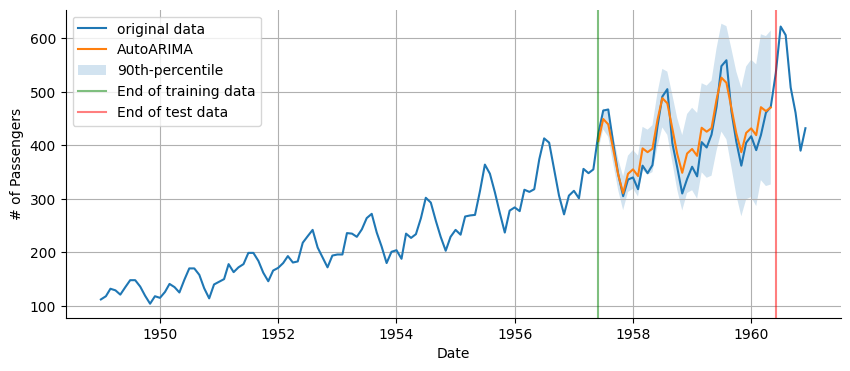

In [21]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Date")
ax.set_ylabel("# of Passengers")
sns.lineplot(data=df, x='ds', y='y', label='original data', ax=ax)
sns.lineplot(data=forecast_df, x='ds', y='AutoARIMA', label='AutoARIMA', ax=ax)
plt.fill_between(forecast_df.ds, forecast_df['AutoARIMA-lo-90'], forecast_df['AutoARIMA-hi-90'], alpha=0.2, label='90th-percentile')
plt.axvline(x=df['ds'][101], color = 'g', label = 'End of training data', alpha=0.5)
plt.axvline(x=df['ds'][137], color = 'r', label = 'End of test data', alpha=0.5)
plt.grid(visible=True)
plt.legend()
sns.despine()
plt.show()

#### Same plot as above, but limited to 1957 data to latest so that the plot is "zoomed" onto our test data range

NOTE: Using pandas dataframe.query() method to choose date range

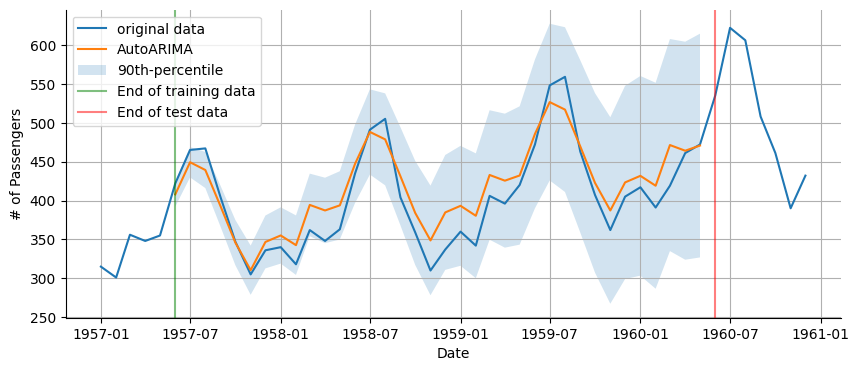

In [22]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Date")
ax.set_ylabel("# of Passengers")
sns.lineplot(data=df.query("ds >= '1957-01-01'"), x='ds', y='y', label='original data', ax=ax)
sns.lineplot(data=forecast_df, x='ds', y='AutoARIMA', label='AutoARIMA', ax=ax)
plt.fill_between(forecast_df.ds, forecast_df['AutoARIMA-lo-90'], forecast_df['AutoARIMA-hi-90'], alpha=0.2, label='90th-percentile')
plt.axvline(x=df['ds'][101], color = 'g', label = 'End of training data', alpha=0.5)
plt.axvline(x=df['ds'][137], color = 'r', label = 'End of test data', alpha=0.5)
plt.grid(visible=True)
plt.legend()
sns.despine()
plt.show()

From above, we see that the model's prediction during the test data range seems reasonable.  So let's fit the model with the entire data set and make prediction for the next 24 months.

## Train model with the entire, original data set

In [23]:
df.head()

,unique_id,ds,y
0,AirPassengers,1949-01-01,112
1,AirPassengers,1949-02-01,118
2,AirPassengers,1949-03-01,132
3,AirPassengers,1949-04-01,129
4,AirPassengers,1949-05-01,121


In [24]:
sf.fit(df)

StatsForecast(models=[AutoARIMA])

In [25]:
forecast2_df = sf.predict(h=24, level=[90]) 

In [26]:
forecast2_df.head()

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
AirPassengers,1961-01-01,444.300049,424.896637,463.703461
AirPassengers,1961-02-01,418.210022,394.525726,441.894318
AirPassengers,1961-03-01,446.237030,418.025269,474.448792
AirPassengers,1961-04-01,488.228943,456.368835,520.088989
AirPassengers,1961-05-01,499.231354,464.033234,534.429504


## Prediction

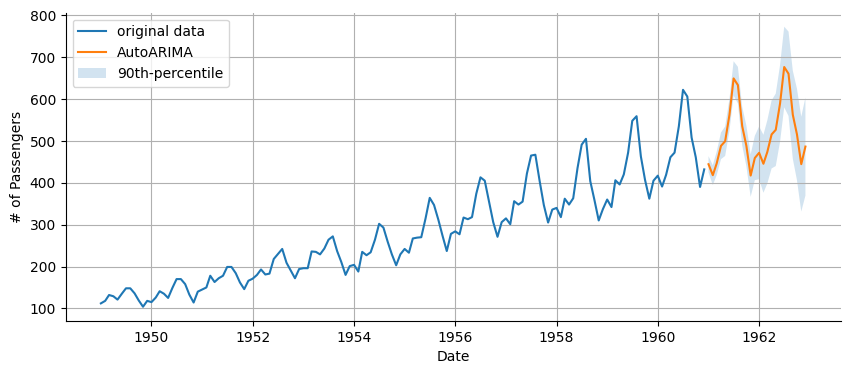

In [27]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Date")
ax.set_ylabel("# of Passengers")
sns.lineplot(data=df, x='ds', y='y', label='original data', ax=ax)
sns.lineplot(data=forecast2_df, x='ds', y='AutoARIMA', label='AutoARIMA', ax=ax)
plt.fill_between(forecast2_df.ds, forecast2_df['AutoARIMA-lo-90'], forecast2_df['AutoARIMA-hi-90'], alpha=0.2, label='90th-percentile')
plt.grid(visible=True)
plt.legend()
sns.despine()
plt.show()